In [4]:
#import 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.diagnostic import linear_rainbow

%matplotlib inline

### Setup model

In [6]:
df = pd.read_csv('./data/kc_house_data.csv',
                parse_dates=['date'])

df.drop(['id', 'floors',
         'heat_source','lat','long'], axis=1, inplace=True)

# Create zip from address
df['zip'] = [x.split(',')[2][-5:] for x in df['address']] 

#https://www.zillow.com/browse/homes/wa/king-county/  - remove all records with zipcodes that dont start with '98'
df = df[df.zip.str.startswith(('98'))]

df['city'] = [x.split(',')[1][0:] for x in df['address']]

#create sale year column from datetime date info
df['sale_year'] = pd.DatetimeIndex(df['date']).year.astype(int)

df['sale_year'].value_counts()


#create new column - age of house
df['home_age'] = (df['sale_year']+1) - df['yr_built']

#create new column - time since reno
df['yr_from_reno'] = (df['sale_year']+1) - df['yr_renovated']

# create filter for yr_from_reno to ID houses that haven't been renovated
reno_filter = df['yr_from_reno'] > 2000

# create new column for design_age to see time since build if no reno, or time since reno if renovated
# first set to reno age
df['design_age'] = df['yr_from_reno']
#then update columns where there was no reno to age of the home
df['design_age'].loc[reno_filter] = df['home_age']

#some houses were sold before they were built - we need to change those records to 0

prebuild_filter = df['design_age'] < 1

df['design_age'].loc[prebuild_filter] = 1


grade_cat = df[['grade']]
grade_categories = ['1 Cabin', '2 Substandard', '3 Poor', '4 Low', '5 Fair', '6 Low Average',
                    '7 Average', '8 Good', '9 Better', '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion']
encoder_grade = OrdinalEncoder(categories=[grade_categories])
encoder_grade.fit(grade_cat)
grade_encoded_train = encoder_grade.transform(grade_cat)
grade_encoded_train = grade_encoded_train.flatten()
df["grade"] = grade_encoded_train

C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [7]:
# Update df to only include homes tham meet minimum code requirements - Average construction grade + design
# Finish work is 'better' and 'more' design quality

grade_filter1 = df["grade"] > 5 
grade_filter2 = df["grade"] < 11

df = df.loc[grade_filter1 & grade_filter2]

In [8]:
# Update df to only include cities with 30+ homes accounted for
df_city = df.groupby('city').count()['price'].reset_index()
city_columns = df_city[ df_city['price'] >= 30 ].transpose()
city_columns.columns = city_columns.iloc[0]
# len(city_columns.columns)

drop_city = df.groupby('city').count()['price'].reset_index()
drop_city_columns = drop_city[ drop_city['price'] < 30 ].transpose()
drop_city_columns.columns = drop_city_columns.iloc[0]
drop_city_columns.columns

drop_city = list(drop_city_columns.columns)

for city in drop_city:
    df = df[~df.city.str.contains(city)]

In [9]:
# Update df to only include homes with living_sqft > 1100
# Accounts for 360sqft garage

sqft_filter1 = df["sqft_living"] > 1100
df = df.loc[sqft_filter1]

In [11]:
# Setup X_train, y_train: apply onehotencoder, ordinalencoder, binary transformations

y = df["price"]
X = df.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)

# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
X_train.loc[X_train['bathrooms'] == 0, 'bathrooms'] = 1
X_train['bathrooms'] = X_train['bathrooms'].apply(np.ceil)


# Create binary substitutes for columns
X_train['basement_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_basement']]
X_train['garage_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_garage']]
X_train['patio_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_patio']]
X_train['waterfront_binary'] = [1 if sq == 'YES'  else 0 for sq in X_train['waterfront']]
X_train['PublicSewer_binary'] = [1 if sq == 'PUBLIC' else 0 for sq in X_train['sewer_system']]
X_train['yrenovated_binary'] = [1 if sq >  0 else 0 for sq in X_train['yr_renovated']]


# Create binary values for greenbelt, nuisance
# Using OneHotEncoder

greenbelt_cat = X_train[['greenbelt']]
encoder_greenbelt = OrdinalEncoder(categories=[['NO', 'YES']])
encoder_greenbelt.fit(greenbelt_cat)
greenbelt_encoded_train = encoder_greenbelt.transform(greenbelt_cat)
greenbelt_encoded_train = greenbelt_encoded_train.flatten()
# greenbelt_encoded_train
X_train["greenbelt"] = greenbelt_encoded_train

nuisance_cat = X_train[['nuisance']]
encoder_nuisance = OrdinalEncoder()
encoder_nuisance.fit(nuisance_cat)
nuisance_encoded_train = encoder_nuisance.transform(nuisance_cat)
nuisance_encoded_train = nuisance_encoded_train.flatten()
X_train["nuisance"] = nuisance_encoded_train

# Create Ordinal Values for condition
# Using OneHotEncoder
condition_cat = X_train[['condition']]
condition_categories = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
encoder_condition = OrdinalEncoder(categories=[condition_categories])
encoder_condition.fit(condition_cat)
condition_encoded_train = encoder_condition.transform(condition_cat)
condition_encoded_train = condition_encoded_train.flatten()
X_train["condition"] = condition_encoded_train

# Create Ordinal Values for view
# Using OneHotEncoder
view_cat = X_train[['view']]
view_categories = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
encoder_view = OrdinalEncoder(categories=[view_categories])
encoder_view.fit(view_cat)
view_encoded_train = encoder_view.transform(view_cat)
view_encoded_train = view_encoded_train.flatten()
X_train["view"] = view_encoded_train


# (1) Create a variable zip
# extracted from df
# (double brackets due to shape expected by OHE)
city_train = X_train[["city"]]

ohe_city = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")

# (3) Fit the encoder on fireplace_qu_train
ohe_city.fit(city_train)

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
city_encoded_train = ohe_city.transform(city_train)

# Visually inspect fireplace_qu_encoded_train
city_encoded_train

# (5a) Make the transformed data into a dataframe
city_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    city_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe_city.categories_[0],
    # Set the index to match X_test's index
    index=X_train.index
)

# Run this cell without changes

# (5b) Drop original FireplaceQu column
X_train.drop("city", axis=1, inplace=True)

# Run this cell without changes

# (5c) Concatenate the new dataframe with current X_train
X_train = pd.concat([X_train, city_encoded_train], axis=1)

# Visually inspect X_train
X_train.head()

# (1) Create a variable zip
# extracted from df
# (double brackets due to shape expected by OHE)
fireplace_qu_train = X_train[["zip"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe_zip = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")

# (3) Fit the encoder on fireplace_qu_train
ohe_zip.fit(fireplace_qu_train)

# Inspect the categories of the fitted encoder
ohe_zip.categories_

# Replace None with appropriate code

# (4) Transform fireplace_qu_train using the encoder and
# assign the result to fireplace_qu_encoded_train
fireplace_qu_encoded_train = ohe_zip.transform(fireplace_qu_train)

# Visually inspect fireplace_qu_encoded_train
fireplace_qu_encoded_train

# Run this cell without changes

# (5a) Make the transformed data into a dataframe
fireplace_qu_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    fireplace_qu_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe_zip.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)

# Visually inspect new dataframe
fireplace_qu_encoded_train

# Run this cell without changes

# (5b) Drop original FireplaceQu column
X_train.drop("zip", axis=1, inplace=True)

# Visually inspect X_train

# Run this cell without changes

# (5c) Concatenate the new dataframe with current X_train
X_train = pd.concat([X_train, fireplace_qu_encoded_train], axis=1)

# Visually inspect X_train
X_train.head()

# Create 'total_sqft' by combining sqft_above + sqft_basement + 
# sqft_garage + sqft_patio
X_train['total_sqft'] = X_train['sqft_above'] + X_train['sqft_basement'] + X_train['sqft_garage'] + X_train['sqft_patio']

X_train['weighted__livsqft'] = X_train['sqft_living'] * X_train['grade']

X_train['date'] = pd.to_datetime(X_train['date'], format='%Y-%m-%d')

X_train['date'].head()

#create sale year column from datetime date info
X_train['sale_year'] = pd.DatetimeIndex(X_train['date']).year.astype(int)

X_train['sale_year'].value_counts()

#Binning by decade

X_train['design_decade'] = pd.cut(x=X_train['design_age'], bins=[0, 3, 13, 23, 33, 43, 53, 63, 73,
                                                         83, 93, 103, 113, 123],
                    labels=['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s',
                            '1950s', '1940s', '1930s', '1920s', '1910s', '1900s'])

X_train.design_decade.value_counts()

labels_ordered = ['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s','1950s', '1940s', '1930s', '1920s', '1910s', '1900s']

labels_ordered.reverse()

labels_ordered

# Create Ordinal Values for view
# Using OneHotEncoder
age_cat = X_train[['design_decade']]
age_categories = labels_ordered
encoder_age = OrdinalEncoder(categories=[age_categories])
encoder_age.fit(age_cat)
encoder_age.categories_[0]

age_encoded_train = encoder_age.transform(age_cat)
age_encoded_train = age_encoded_train.flatten()
X_train["design_decade"] = age_encoded_train

X_train["design_decade"]

X_train['yard_size_ratio'] = (X_train['total_sqft'] / X_train['sqft_lot']) * 100

# list(X_train.columns)

C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-11-e208c5ee3da5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['bathrooms'] = X_train['bathrooms'].apply(np.ceil)
<ipython-input-11-e208c5ee3da5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [12]:
# Create additional engineered variables

X_train['view_grade'] = (X_train['view'] + 1) * X_train['grade']
X_train['waterfront_grade'] = (X_train['waterfront_binary'] + 1)  * X_train['grade']
X_train['design_decade_grade'] = (X_train['design_decade'] + 1)  * X_train['grade']
X_train['nuisance_grade'] = (X_train['nuisance'] + 1)  * X_train['grade']
X_train['garage_binary_grade'] = (X_train['garage_binary'] + 1)  * X_train['grade']
X_train['basement_binary_grade'] = (X_train['basement_binary'] + 1)  * X_train['grade']
X_train['patio_binary_grade'] = (X_train['patio_binary'] + 1)  * X_train['grade']
X_train['PublicSewer_binary_grade'] = (X_train['PublicSewer_binary'] + 1)  * X_train['grade']
X_train['condition_grade'] = (X_train['condition'] + 1)  * X_train['grade']



In [13]:
relevant = [' Auburn', ' Bellevue', ' Black Diamond', ' Bothell', ' Burien',
           ' Carnation', ' Clyde Hill', ' Covington', ' Des Moines', ' Duvall',
           ' Enumclaw', ' Fall City', ' Federal Way', ' Issaquah', ' Kenmore',
           ' Kent', ' Kirkland', ' Lake Forest Park', ' Maple Valley', ' Medina',
           ' Mercer Island', ' Newcastle', ' Normandy Park', ' North Bend',
           ' Pacific', ' Ravensdale', ' Redmond', ' Renton', ' Sammamish',
           ' SeaTac', ' Seattle', ' Shoreline', ' Snoqualmie', ' Tukwila',
           ' Vashon', ' Woodinville',
            'weighted__livsqft', 'design_decade', 'yard_size_ratio', 'view_grade',
            'waterfront_grade', 'design_decade_grade', 'nuisance_grade', 'garage_binary_grade',
            'basement_binary_grade', 'patio_binary_grade', 'PublicSewer_binary_grade', 'condition_grade']

X_train = X_train[relevant]

In [14]:
model_train = sm.OLS(y_train, sm.add_constant(X_train)).fit()
results_train = model_train.summary()
results_train

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     699.6
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:00:03   Log-Likelihood:            -2.6415e+05
No. Observations:               18192   AIC:                         5.284e+05
Df Residuals:                   18144   BIC:                         5.288e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -4.273e+05   4.11e+04    -10.384      0.000   -5.08e+05   -3.47e+05
 Auburn                  -4.982e+05   1.72e+04    -28.988      0.000   -5.32e+05   -4.64e+05
 Bellevue                 4.779e+05   1.68e+04     28.531      0.000    4.45e+05    5.11e+05
 Black Diamond            -5.22e+05   3.56e+04    -14.643      0.000   -5.92e+05   -4.52e+05
 Bothell                  1.233e+04   3.42e+04      0.361      0.718   -5.47e+04    7.94e+04
 Burien                  -3.396e+05   2.93e+04    -11.580      0.000   -3.97e+05   -2.82e+05
 Carnation               -2.543e+05   4.92e+04     -5.166      0.000   -3.51e+05   -1.58e+05
 Clyde Hill               2.389e+06   7.21e+04     33.153      0.000    2.25e+06    2.53e+06
 Covington               -4.116e+05   2.87e+04    -14.354      0.000   -4.68e+05   -3.55e+05
 Des Moines              -3.998e+05   3.09e+04    -12.930      0.000    -4.6e+05   -3.39e+05
 Duvall                  -2.566e+05   3.69e+04     -6.960      0.000   -3.29e+05   -1.84e+05
 Enumclaw                -4.637e+05   3.09e+04    -15.020      0.000   -5.24e+05   -4.03e+05
 Fall City                2.923e+05   5.94e+04      4.920      0.000    1.76e+05    4.09e+05
 Federal Way             -5.204e+05   1.89e+04    -27.581      0.000   -5.57e+05   -4.83e+05
 Issaquah                 6.823e+04   2.58e+04      2.642      0.008    1.76e+04    1.19e+05
 Kenmore                 -9.914e+04   3.14e+04     -3.160      0.002   -1.61e+05   -3.76e+04
 Kent                      -4.4e+05   1.64e+04    -26.839      0.000   -4.72e+05   -4.08e+05
 Kirkland                 4.009e+05   1.77e+04     22.700      0.000    3.66e+05    4.35e+05
 Lake Forest Park        -1.085e+05   3.84e+04     -2.822      0.005   -1.84e+05   -3.31e+04
 Maple Valley            -3.542e+05   2.07e+04    -17.115      0.000   -3.95e+05   -3.14e+05
 Medina                   2.436e+06   8.91e+04     27.330      0.000    2.26e+06    2.61e+06
 Mercer Island             6.55e+05   3.18e+04     20.565      0.000    5.93e+05    7.17e+05
 Newcastle               -5.604e+04    4.2e+04     -1.335      0.182   -1.38e+05    2.62e+04
 Normandy Park           -3.898e+05    5.6e+04     -6.955      0.000      -5e+05    -2.8e+05
 North Bend              -2.416e+05   2.79e+04     -8.674      0.000   -2.96e+05   -1.87e+05
 Pacific                 -3.753e+05   7.09e+04     -5.294      0.000   -5.14e+05   -2.36e+05
 Ravensdale              -3.421e+05   7.63e+04     -4.484      0.000   -4.92e+05   -1.93e+05
 Redmond                   2.43e+05   1.95e+04     12.441      0.000    2.05e+05    2.81e+05
 Renton                  -3.158e+05   1.56e+04    -20.197      0.000   -3.46e+05   -2.85e+05
 Sammamish                1.583e+05   1.96e+04      8.097      0.000     1.2e+05    1.97e+05
 SeaTac       

# Test for 4 assumptions of linear regression

## Linearity

In [15]:
fitted_vals = model_train.predict()
resids = model_train.resid

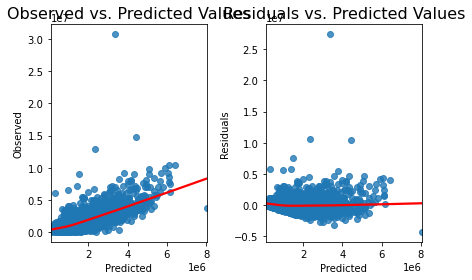

In [18]:
fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=y_train, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
ax[0].set(xlabel='Predicted', ylabel='Observed');

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
ax[1].set(xlabel='Predicted', ylabel='Residuals')

fig.tight_layout()

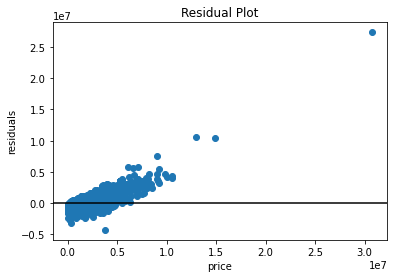

In [19]:
fig, ax = plt.subplots()


ax.scatter(y_train, model_train.resid)
ax.axhline(y=0, color="black")
ax.set_xlabel("price")
ax.set_ylabel("residuals")
ax.set_title("Residual Plot");

### Rainbow test

In [21]:
linear_rainbow(model_train)

(1.5255688826195213, 1.329690584817843e-89)

Since the p value is below alpha, we reject the null hypothesis and do not consider the relationship to be linear. We will need to perform a non-linear transformation on either the target and/or features.

# Independence

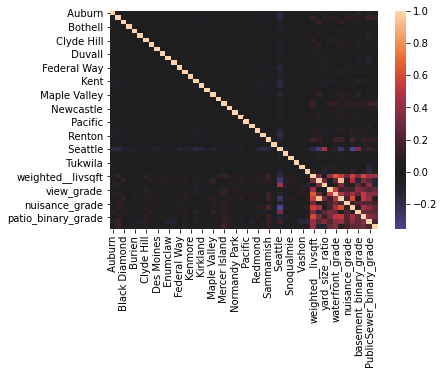

In [23]:
sns.heatmap(X_train.corr(), center=0);

In [24]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_corr=X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))

# set index to pairs
df_corr.set_index(['pairs'], inplace = True)

#d rop level columns
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_corr.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_corr.drop_duplicates(inplace=True)

df_corr[(df_corr.cc>.75) & (df_corr.cc <1)]

,cc
pairs,
"(design_decade_grade, design_decade)",0.9361


We can see design_decade_grade and design_decade have a high correlation of 0.94, so there is some multicollinearity.

# Normality

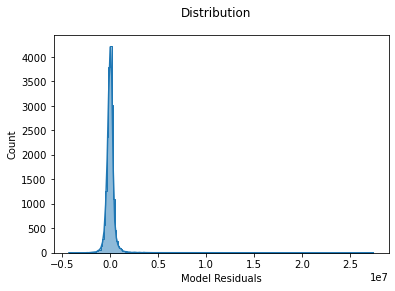

In [25]:
# Histogram of residuals
fig, ax = plt.subplots()
sns.histplot(model_train.resid, bins=200, element="step", kde=True, ax=ax)
ax.set_xlabel("Model Residuals")
fig.suptitle("Distribution");

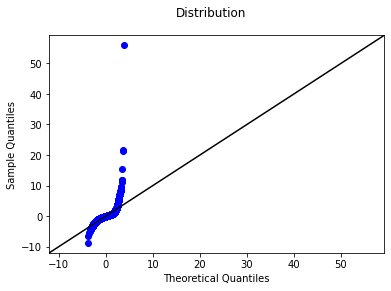

In [26]:
# Q-Q plot
# Use qqplot function from StatsModels
fig, ax = plt.subplots()
sm.graphics.qqplot(model_train.resid, dist=stats.norm, line='45', fit=True, ax=ax)

# Customize plot appearance
line = ax.lines[1]
line.set_color("black")
fig.suptitle("Distribution");

In [28]:
jarque_bera(model_train.resid)

(252976656.20101586, 0.0, 12.435573034886852, 580.1687072215848)

To determine the normality of the model, we can look at the histogram of residuals and QQ plot. We can also reference the Jarque-Bera test results.

JB: 252976656

P(JB): 0.0

We can reject the null hypothesis as the residual P value is below alpha, and so the distribution is not normal.

The fix is to transform non-normal features or the target by applying a log transform.

# Equal Variance(Homoskedacity)

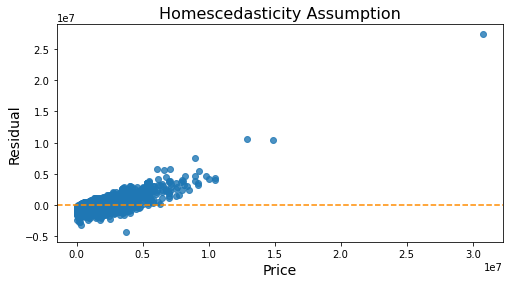

In [30]:
# Plotting the residuals
plt.subplots(figsize=(8, 4))
plt.scatter(x=y_train, y=model_train.resid, alpha=0.8)
plt.axhline(y=0, color='darkorange', linestyle='--')

plt.ylabel('Residual', fontsize=14)
plt.xlabel('Price', fontsize=14)
plt.title('Homescedasticity Assumption', fontsize=16)
plt.show();

In [31]:
# Goldfeld-Quandt test:
het_goldfeldquandt(y_train, X_train, alternative='two-sided')

(0.7031817374018133, 1.2150576161378659e-62, 'two-sided')

For this data, we have a p value below alpha. We can reject the null hypothesis, so the model is heteroscedastic.